In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import constants as const
from phidl import quickplot as qp
from phidl import Device
from phidl import CrossSection
from phidl import Path
import phidl.geometry as pg
import phidl.routing as pr
import phidl.path as pp
import pprint

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / 'util/'))
from qubit_templates import *

In [3]:
feedline_resonator_gap = 13 
n_gridline = 20
JJtype = "mh" # mh or dl (manhattan or dolan)
Bandage = True 
DCLine = True # Add DC line next to squids
Entangle = True # Connect two transmons

outname = "waferdesign_" + JJtype
if Bandage:
    outname += "bd"
if DCLine:
    outname += "_dcline"
if Entangle:
    outname += "_entangle"    

# Wafer design

In [4]:
wafer = device_Wafer(inch = 4)

# Chip design

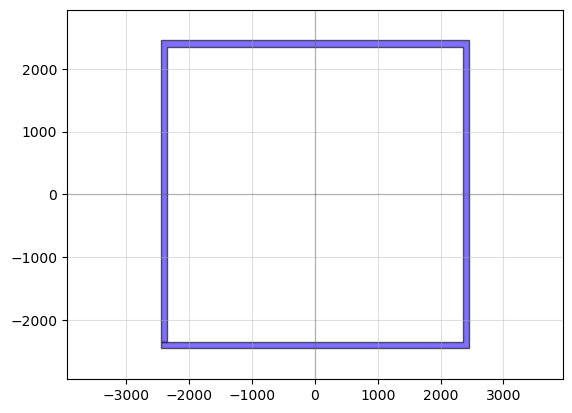

In [5]:
chipdesign = Device('chipdesign')

FM=Device('frame')
rectangle = pg.rectangle((4700, 4700), 25)
FM.add_ref( pg.invert(rectangle, border = 100, precision = 1e-6, layer = 25) )
FM.center = (0, 0)

chipdesign.add_ref(FM)
# Quickplot the imported design
qp(chipdesign)

# Launch pad

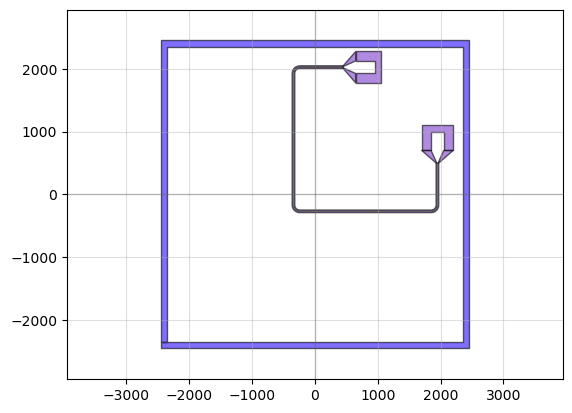

In [6]:
FL = device_FeedLine()
chipdesign.add_ref(FL)
qp(chipdesign)


# Corner points

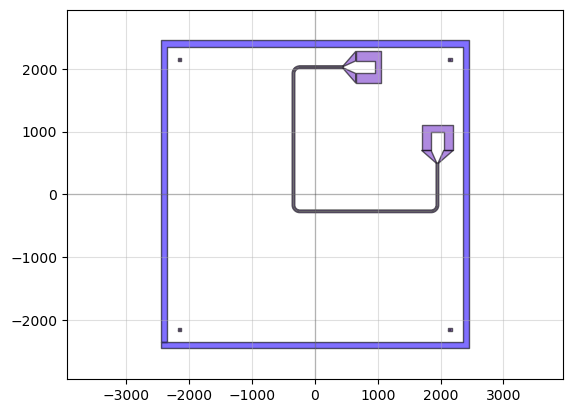

In [7]:
CP = device_CornerPoints()
chipdesign.add_ref(CP)
qp(chipdesign)

# Test Areas

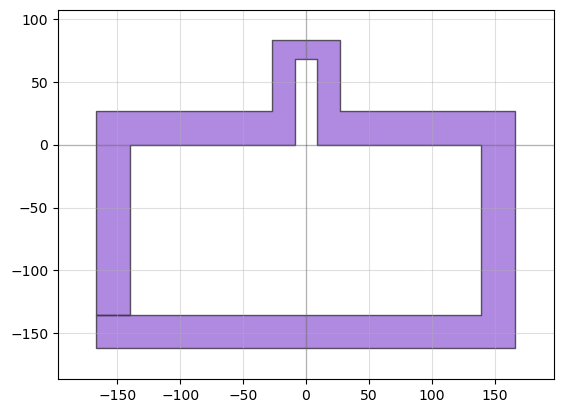

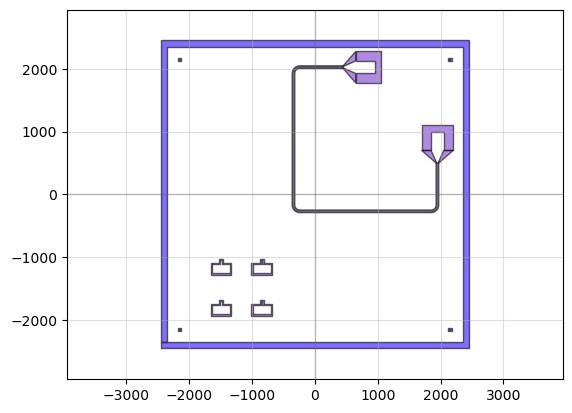

In [8]:
TA = device_TestAreas(DCLine = DCLine)
chipdesign.add_ref(TA)
qp(chipdesign)

# Resonator

Length : 3935.2841353212234 [um]
Length : 4045.2841353212234 [um]
Length : 4323.093481820941 [um]
Length : 4183.093481820941 [um]


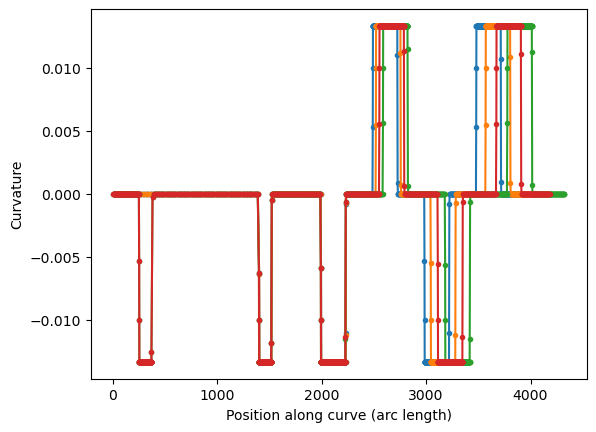

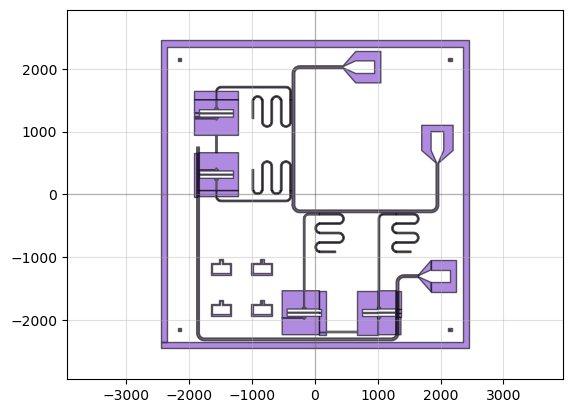

In [9]:
R1_tmp = device_Resonator(resonator_straight1 = 220, resonator_straight2 = 260, resonator_straight3 = 475, resonator_straight4 = 1400, entangle = Entangle)
R1_tmp.movex(1315)
R1_tmp.ymax = FL.ymin - feedline_resonator_gap
R1 = pg.copy_layer(R1_tmp, 4, 4)
chipdesign.add_ref(R1)

R2_tmp = device_Resonator(resonator_straight1 = 240, resonator_straight2 = 290, resonator_straight3 = 475, resonator_straight4 = 1400, entangle = Entangle)
R2_tmp.movex(145)
R2_tmp.ymax = FL.ymin - feedline_resonator_gap
R2 = pg.copy_layer(R2_tmp, 4, 4)
chipdesign.add_ref(R2)

if Entangle:
    R3_tmp = device_Resonator(resonator_straight1 = 310, resonator_straight2 = 360, resonator_straight3 = 475, resonator_straight4 = 1030, side = True, mirror = True, entangle = Entangle)
else:
    R3_tmp = device_Resonator(resonator_straight1 = 310, resonator_straight2 = 360, resonator_straight3 = 475, resonator_straight4 = 1030, side = True, mirror = False, entangle = Entangle)
R3_tmp.movey(408)
R3_tmp.xmax = FL.xmin - feedline_resonator_gap
R3 = pg.copy_layer(R3_tmp, 4, 4)
chipdesign.add_ref(R3)

R4_tmp = device_Resonator(resonator_straight1 = 275, resonator_straight2 = 325, resonator_straight3 = 475, resonator_straight4 = 1030, side = True, entangle = Entangle)
R4_tmp.movey(1383)
R4_tmp.xmax = FL.xmin - feedline_resonator_gap
R4 = pg.copy_layer(R4_tmp, 4, 4)
chipdesign.add_ref(R4)

if Entangle:
    # Line_1to2 = Device("Line1to2")
    # Line_3to4 = Device("Line3to4")

    X = CrossSection()
    line_width = 10
    line_gap_width = 6
    X.add(width= line_width, offset = 0, layer = 1)
    X.add(width= line_gap_width, offset = 0.5*(line_width + line_gap_width), layer = 4)
    X.add(width= line_gap_width, offset = -0.5*(line_width + line_gap_width), layer = 4)

    line_1to2 = pr.route_smooth(
        port1 = R1_tmp.references[0].ports['entangle'],
        port2 = R2_tmp.references[0].ports['entangle'],
        width = X,
        radius = 75,
        path_type = 'U',
        length1 = 120 + 75,
        smooth_options=  {'corner_fun': pp.arc}
        )
    
    line_3to4 = pr.route_smooth(
        port1 = R3_tmp.references[0].ports['entangle'],
        port2 = R4_tmp.references[0].ports['entangle'],
        width = X,
        path_type = 'straight')    

    chipdesign = pg.boolean(chipdesign, pg.copy_layer(line_1to2, 1, 4), 'not', layer = 4)
    chipdesign = pg.boolean(chipdesign, pg.copy_layer(line_3to4, 1, 4), 'not', layer = 4)
    chipdesign.add_ref( pg.copy_layer(line_1to2, 4, 4) )
    chipdesign.add_ref( pg.copy_layer(line_3to4, 4, 4) )


if DCLine:
    DC_tmp = device_DCLine()
    DC = pg.copy_layer(DC_tmp, 4, 4)
    DC_subtract = pg.copy_layer(DC_tmp, 1, 1)
    chipdesign = pg.boolean(chipdesign, DC_subtract, 'not', layer = 4)
    chipdesign.add_ref(DC)

chipdesign.write_gds('output/dcline.gds')
qp(chipdesign)

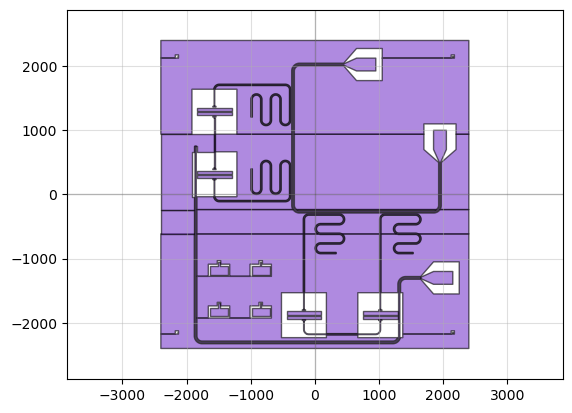

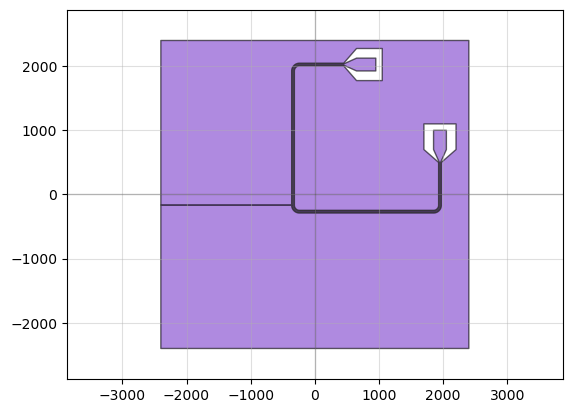

'output/chipdesign_onlyFL_simulation.gds'

In [10]:
# Produce inverted version for simulation
chipdesign_inverted = Device('chipdesign_inverted')
chipdesign_inverted_FL = Device('chipdesign_inverted_FL')
chipdesign_inverted.add_ref(FL)
chipdesign_inverted_FL.add_ref(FL)
chipdesign_inverted.add_ref(R1_tmp)
chipdesign_inverted.add_ref(R2_tmp)
chipdesign_inverted.add_ref(R3_tmp)
chipdesign_inverted.add_ref(R4_tmp)
chipdesign_inverted.add_ref(CP)
chipdesign_inverted.add_ref(TA)
if DCLine:
    chipdesign_inverted.add_ref(DC_tmp)
if Entangle:
    chipdesign_inverted.add_ref(line_1to2)
    chipdesign_inverted.add_ref(line_3to4)

rectangle = pg.bbox([(-2400, -2400),(2400, 2400)], 0)
trace = pg.copy_layer(chipdesign_inverted, 1, 4)
chipdesign_inverted = pg.boolean(rectangle, chipdesign_inverted, operation = 'not', layer = 4)
chipdesign_inverted_FL = pg.boolean(rectangle, chipdesign_inverted_FL, operation = 'not', layer = 4)

chipdesign_inverted.add_ref(trace)

qp(chipdesign_inverted)
qp(chipdesign_inverted_FL)

chipdesign_inverted.write_gds('output/chipdesign_simulation.gds')
chipdesign_inverted_FL.write_gds('output/chipdesign_onlyFL_simulation.gds')

# Josephson Junction

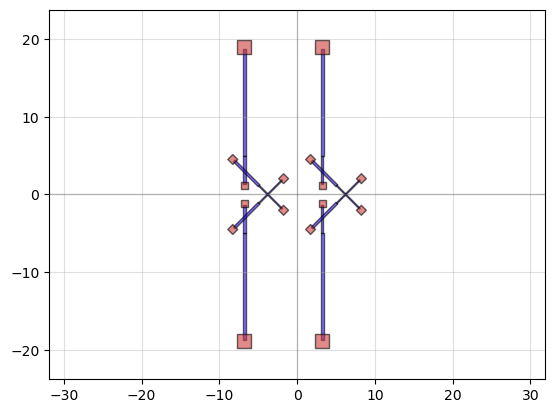

In [11]:
# JJ = device_JJ(width = 0.3, JJtype = "manhattan", squid = True, bandage = False)
# JJ = device_JJ(width = 0.3, JJtype = "manhattan", squid = False, bandage = False)
JJ = device_JJ(width = 0.135, JJtype = "manhattan", squid = True, bandage = True)
# JJ = device_JJ(width = 0.135, JJtype = "manhattan", squid = False, bandage = True)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = True, bandage = False)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = False, bandage = False)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = True, bandage = True)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = False, bandage = True)
qp(JJ)


# Add test boxes for EB

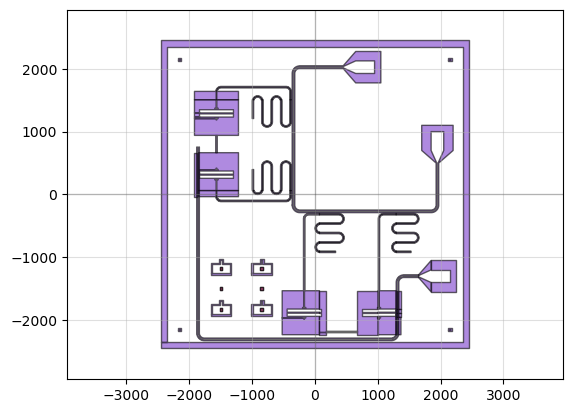

In [12]:
BX = device_TestBoxes(DCLine = DCLine)
chipdesign.add_ref(BX)
qp(chipdesign)

# Add JJ to chip design

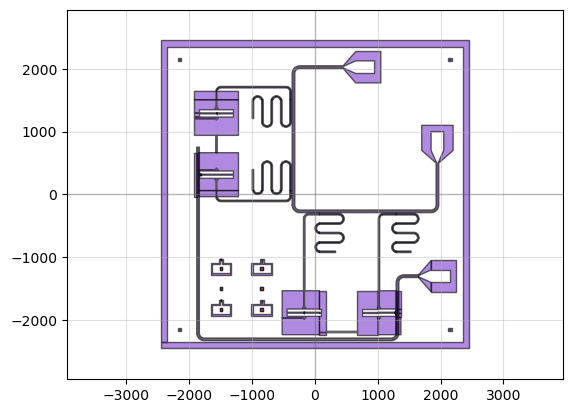

'output/chipdesign.gds'

In [13]:
def custom_chip(width, height):
    chip = Device('chip')
    chip.add_ref(chipdesign)

    JJ_trans = device_JJ(width = width, JJtype = JJtype, squid = False, bandage = Bandage)
    JJ_squid = device_JJ(width = width, JJtype = JJtype, squid = True , bandage = Bandage)
    EBLine = device_EBLine()

    # SQUID
    chip.add_ref(JJ_squid).movex(1280).movey(-1880)
    # transmon
    chip.add_ref(JJ_trans).movex(-172).movey(-1880)
    # SQUID
    chip.add_ref(JJ_squid).movex(-1815).movey(315)    
    # transmon
    chip.add_ref(JJ_trans).movex(-1560).movey(1290)

    # transmon (test)
    if DCLine:
        chip.add_ref(JJ_trans).movex(-1493).movey(-1689)
        chip.add_ref(JJ_trans).movex(-1493).movey(-1038)
        chip.add_ref(EBLine).movex(-843).movey(-1689)
        chip.add_ref(EBLine).movex(-843).movey(-1038)
    else:
        chip.add_ref(JJ_trans).movex(-1743).movey(-1739)
        chip.add_ref(JJ_trans).movex(-1743).movey(-1088)
        chip.add_ref(EBLine).movex(-1093).movey(-1739)
        chip.add_ref(EBLine).movex(-1093).movey(-1088)    

    return chip

chip = custom_chip(width = 0.135, height = None)
qp(chip)
chip.write_gds('output/chipdesign')

# Place chip designs

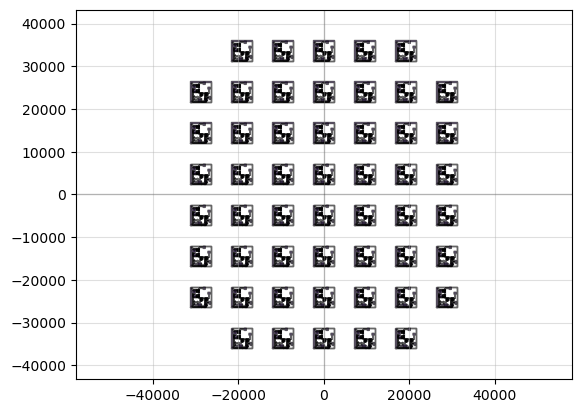

In [14]:


D = pg.gridsweep(
    function = custom_chip,
    param_x = {'width' :  [0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165]},
    param_y = {'height' : [10, 10, 10, 10, 10, 10, 10, 10]},
    spacing = (4700,4700),
    label_layer = None
    )
D.center = (0,0)
# D = D.movex(-6*4800).movey(-7*4800)
# pprint.pprint(D.references)

## Remove corners
xmin = min([ref.center[0] for ref in D.references])
xmax = max([ref.center[0] for ref in D.references])
ymin = min([ref.center[1] for ref in D.references])
ymax = max([ref.center[1] for ref in D.references])
for ref in D.references:
    # print( ref.center )
    # print( ref.size )
    if (ref.center == (xmin, ymin)).all() or (ref.center == (xmax, ymin)).all() or (ref.center == (xmin, ymax)).all() or (ref.center == (xmax, ymax)).all():
        D.remove(ref)
wafer.add_ref(D)
qp(D)


# Add EB markers

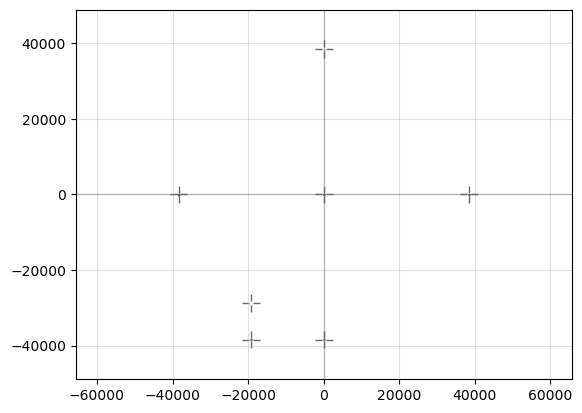

DeviceReference (parent Device "EBmarkers", ports [], origin (0, 0), rotation 0, x_reflection False)

In [15]:
marker_pos = [(0,0),(0,38400),(-19200,-28800),(38400,0),
              (0,-38400),(-19200,-38400),(-38400,0)]
EBmarkers = device_EBmarkers(marker_pos = marker_pos, layer = 3)
qp(EBmarkers)
wafer.add_ref(EBmarkers)


# Add grid lines

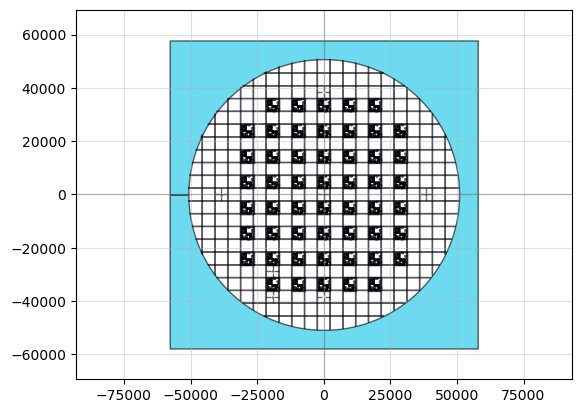

In [16]:
grid = device_Grid(inch = 4, n_gridline = n_gridline)
wafer.add_ref( grid )

qp(wafer)


In [17]:
wafer.write_gds('output/' + outname)

'output/waferdesign_mhbd_dcline_entangle.gds'